In [13]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.externals import joblib

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, LabelEncoder

from Autoencoder_Utils import print_features_histograms, plot_difference_displ, print_features_histograms_displ

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '1'

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Lambda, BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.objectives import binary_crossentropy, mse
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)
%matplotlib inline

## Define AE

In [5]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5*z_log_var) * epsilon

def create_vae_aux(n_features, encoding_dim, n_aux_features=5, n_mc_features=6, p_drop=0.5, n_layers=3, thickness=2):
    # Encoder
    inputs = Input(shape=(n_features, ), name='main_input')
    aux_inputs = Input(shape=(n_aux_features, ), name='aux_inputs')
    mc_inputs = Input(shape=(n_mc_features, ), name='mc_inputs')
    
    x = keras.layers.concatenate([inputs, aux_inputs, mc_inputs])

    for i in range(n_layers - 1):
        x = Dense(thickness * n_features // (i+1), activation='relu')(x)
        x = keras.layers.concatenate([x, aux_inputs, mc_inputs])

    
    x = Dense(thickness * encoding_dim, activation='relu')(x)
    x = keras.layers.concatenate([x, aux_inputs, mc_inputs])

    encoded_mu = Dense(encoding_dim, name='encoded_mu')(x)
    encoded_sigma = Dense(encoding_dim, name='encoded_sigma')(x)
    encoded = Lambda(sampling, output_shape=(encoding_dim,), name='encoded')([encoded_mu, encoded_sigma])

    
    # Decoder
    input_encoded = Input(shape=(encoding_dim, ))
    
    x = keras.layers.concatenate([input_encoded, aux_inputs, mc_inputs])
    x = Dense(thickness * encoding_dim, activation='relu')(x)
    
    for i in range(n_layers - 2, -1, -1):
        x = keras.layers.concatenate([x, aux_inputs, mc_inputs])
        x = Dense(thickness * n_features // (i+1), activation='relu')(x)
        
    decoded = Dense(n_features, activation='sigmoid')(x)
    
    
    # Models
    encoder = Model([inputs, aux_inputs, mc_inputs], [encoded_mu, encoded_sigma, encoded], name="encoder")
    decoder = Model([input_encoded, aux_inputs, mc_inputs], decoded, name="decoder")
    
    outputs = decoder([encoder([inputs, aux_inputs, mc_inputs])[2], aux_inputs, mc_inputs])
    autoencoder = Model(
        [inputs, aux_inputs, mc_inputs], outputs, name="autoencoder"
    )

    # opt
    optimizer_adam = optimizers.Adam(lr=0.001)
    
    # loss
    reconstruction_loss = binary_crossentropy(inputs, outputs)
    reconstruction_loss *= n_features
    kl_loss = 1 + encoded_sigma - K.square(encoded_mu) - K.exp(encoded_sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss) 
    autoencoder.add_loss(vae_loss)
    autoencoder.compile(optimizer=optimizer_adam)
    
    return autoencoder, encoder, decoder

## Посмотрим на результаты работы автоэнкодеров

Загрузка сохраненных данных

In [7]:
#Load Output from Neural Network training
TYPE = "" # 100% of the data. To determine the real performance of the cross check
#TYPE = "_10perc" #10% of the data. Used for everything except to determine the real performance of the cross check
#TYPE = "_1perc" #1% of the data. For small tests.
#TYPE = "_100" #100 samples of the data. For very rudimentary tests

pids = ['a', 'b', 'c', 'd', 'e']

retain_dict = pickle.load( open("VAE_retain_dict.p", "rb" ) )

test_input = retain_dict.pop("test_input")
test_aux = retain_dict.pop("test_aux")
test_MC = retain_dict.pop("test_MC")

save_decoded_dict = retain_dict.pop("save_decoded_dict")
save_decoded_dict_dec = retain_dict.pop("save_decoded_dict_dec")

vars_list_input = retain_dict.pop("vars_list_input")
vars_list_aux = retain_dict.pop("vars_list_aux")
vars_list_MC = retain_dict.pop("vars_list_mc")

l_encoding_dim = list(save_decoded_dict.keys())

Зависимость MSE от encoding_dim

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

# Classification

### sampling from VAE

In [2]:
DATA_PATH = "./csv/"

xgb_train = pd.read_csv(DATA_PATH+"xgb_data.csv", index_col=0)
vae_train_unscaled = pd.read_csv(DATA_PATH+"vae_train.csv", index_col=0)
vae_test_unscaled = pd.read_csv(DATA_PATH+"vae_test.csv", index_col=0)
vae_train = pd.read_csv(DATA_PATH+"vae_train_scaled.csv", index_col=0)
vae_test = pd.read_csv(DATA_PATH+"vae_test_scaled.csv", index_col=0)

In [10]:
xgb_input = xgb_train[vars_list_input].values
xgb_aux   = xgb_train[vars_list_aux].values
xgb_MC    = xgb_train[vars_list_MC].values

le = LabelEncoder()
y = le.fit_transform(xgb_MC[:, 0])

In [11]:
test_size = 0.3

idx_train_clf, idx_test_clf = train_test_split(np.arange(xgb_input.shape[0]), stratify=y, 
                                               random_state=42, test_size=test_size)
X_train, X_test = xgb_input[idx_train_clf], xgb_input[idx_test_clf]
y_train, y_test = y[idx_train_clf], y[idx_test_clf]

X_train_aux, X_test_aux = xgb_aux[idx_train_clf], xgb_aux[idx_test_clf]

X_train_mc, X_test_mc = xgb_MC[idx_train_clf], xgb_MC[idx_test_clf]

In [45]:
xgb_train = pd.DataFrame(np.concatenate([X_train, X_train_aux, X_train_mc], axis=1), columns=vars_list_input+vars_list_aux+vars_list_MC)
xgb_train["pid"] = y_train
xgb_train.to_csv("xgb_train_data.csv")

xgb_test = pd.DataFrame(np.concatenate([X_test, X_test_aux, X_test_mc], axis=1), columns=vars_list_input+vars_list_aux+vars_list_MC)
xgb_test["pid"] = y_test
xgb_test.to_csv("xgb_test_data.csv")

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
clf_name = "XGBoost_old_{}".format(9)
clf = xgb.XGBClassifier(nthread=-1, seed=111)
clf.fit(X_train, y_train)
joblib.dump(clf, os.path.join('xgboost', clf_name) + ".pkl")
# clf = joblib.load(os.path.join('xgboost', clf_name) + ".pkl")

['xgboost/XGBoost_old_9.pkl']

In [28]:
from collections import defaultdict
samples = {}
samples_y = {}

scalers = {}
for var in (vars_list_input + vars_list_aux):
    scalers[var] = {
        'std': joblib.load(os.path.join('preprocessors', "VAE_scaler_std_"+var) + ".pkl"),
        'max': joblib.load(os.path.join('preprocessors', "VAE_scaler_max_"+var) + ".pkl")
    }

for enc_dim in l_encoding_dim:
    autoencoder, encoder, decoder = create_vae_aux(
        test_input.shape[1], enc_dim, 
        n_aux_features=test_aux.shape[1],
        n_layers=4, thickness=64
    )
    autoencoder.load_weights("./checkpoints/vae_bc_{}.hdf5".format(enc_dim))
    
    le_mc = joblib.load(os.path.join('preprocessors', "le_mc") + ".pkl")
    
    latent_var = [np.random.normal(0, 1, enc_dim) for i in range(len(vae_test))]
    decoded_test = decoder.predict([latent_var, vae_test[vars_list_aux].values, le_mc.transform(vae_test[vars_list_MC].values)])
    
    decoded_unscaled = decoded_test.copy()
    for i, var in enumerate(vars_list_input):
        decoded_unscaled[:, i] = scalers[var]['std'].inverse_transform(
            scalers[var]['max'].inverse_transform(decoded_unscaled[:, i].reshape(-1, 1))
        ).reshape(-1)
        
    samples[enc_dim] = decoded_unscaled  
    samples_y[enc_dim] = le.transform(vae_test[vars_list_MC].values.ravel())

In [20]:
from helpers import *

In [21]:
path_to_metrics = './metrics/'
metrics_dir_name = "vae"

In [22]:
metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

---------------------

In [25]:
y_proba.shape

(1472537, 6)

In [26]:
y_real.shape

(98169,)

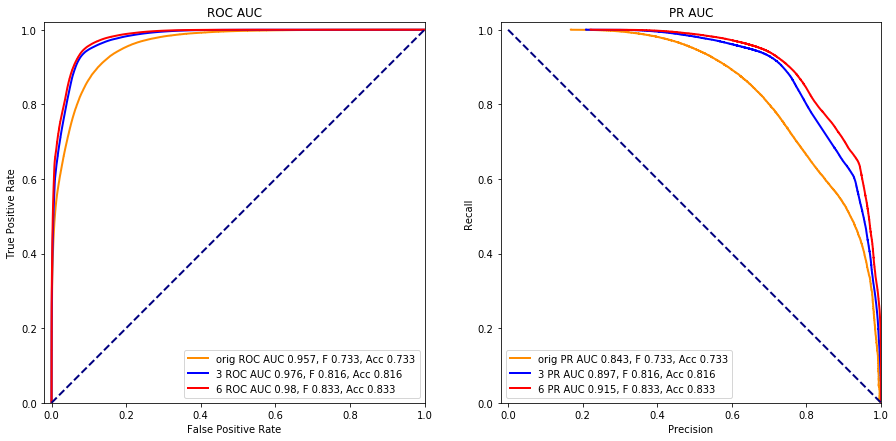

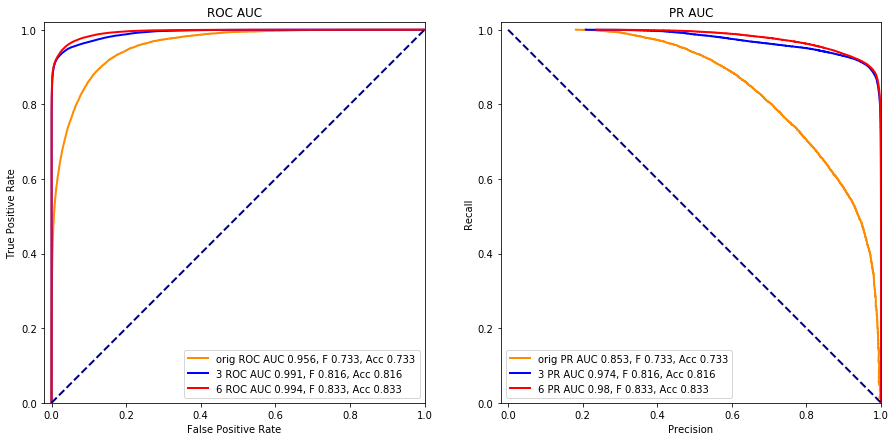

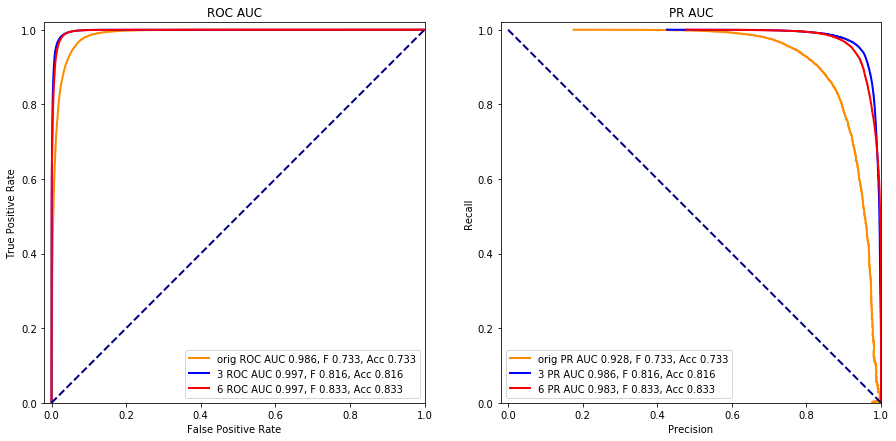

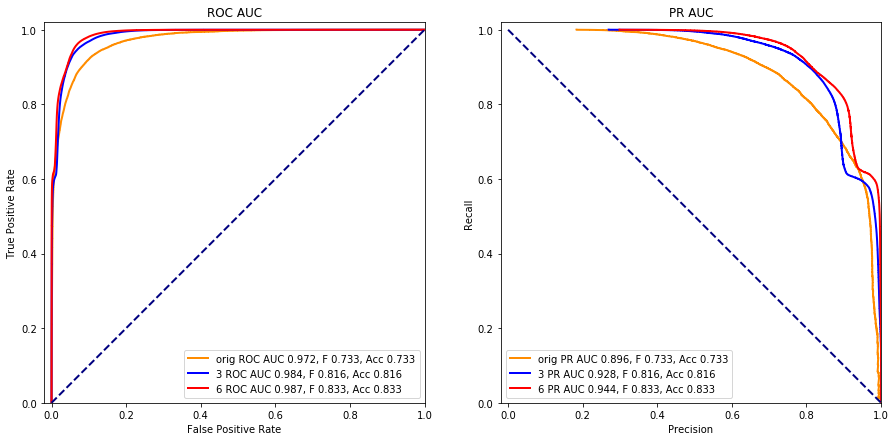

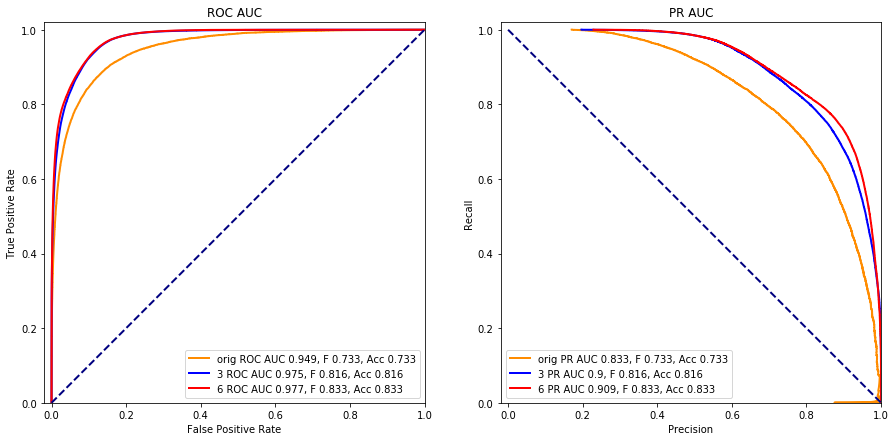

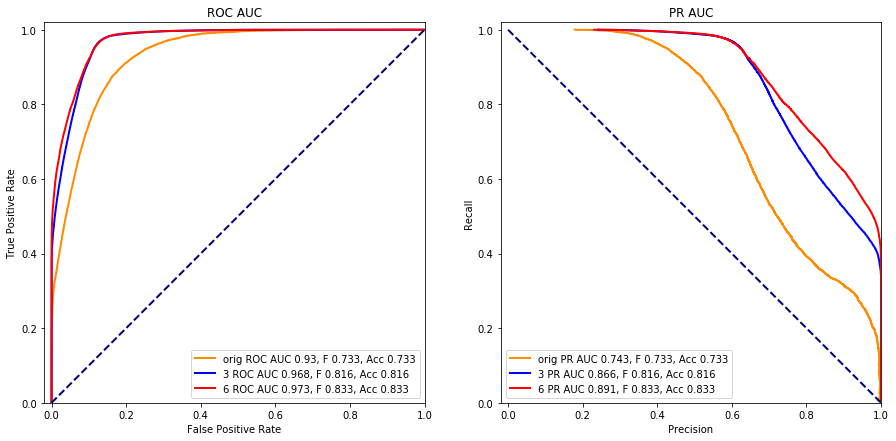

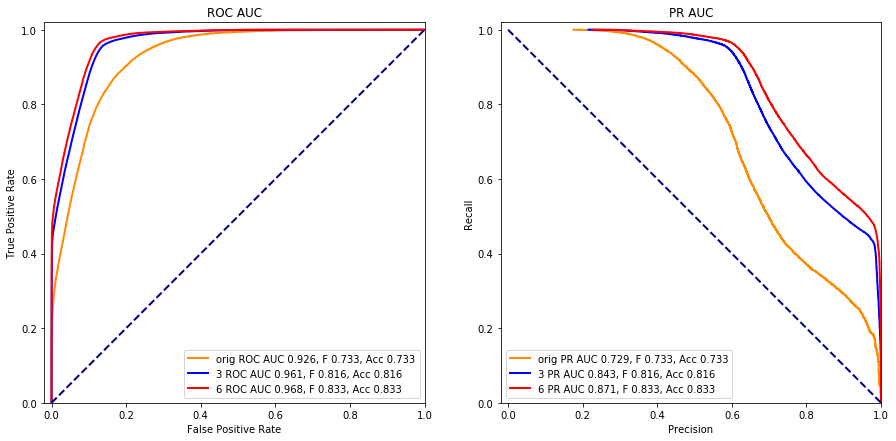


100%|██████████| 3/3 [05:28<00:00, 109.34s/it]


In [29]:
import os
for encoding_dim in tqdm(["orig"] + l_encoding_dim):
    if encoding_dim == "orig":
        y_proba = clf.predict_proba(X_test)
        y_real = y_test
    else:
        y_proba = clf.predict_proba(samples[encoding_dim])
        y_real = samples_y[encoding_dim].ravel()
    y_pred = np.argmax(y_proba, axis=1)
    y_bin = label_binarize(y_real, classes=np.unique(y_real))
    
    # Compute ROC/PR curve and ROC/PR area for each class
    for pid_label in np.unique(y_real):
        idx = np.where(y_real == pid_label)[0]
        cur_y = np.where(y_real == pid_label, np.ones_like(y_real), np.zeros_like(y_real))
        cur_y_proba = y_proba[:, pid_label]
        
        pid_label = str(pid_label)
        metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], _ = \
            roc_curve(cur_y, cur_y_proba)
        metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], _ = \
            precision_recall_curve(cur_y, cur_y_proba)
        
        metrics_dict['roc_auc'][encoding_dim][pid_label] = auc(
            metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label])
        metrics_dict['pr_auc'][encoding_dim][pid_label] = average_precision_score(cur_y.ravel(), cur_y_proba.ravel())
        
    metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
        roc_curve(y_bin.ravel(), y_proba.ravel())
    metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
        precision_recall_curve(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
    metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['f_measure'][encoding_dim] = f1_score(y_real, y_pred, average='micro')
    metrics_dict['acc'][encoding_dim] = accuracy_score(y_real, y_pred)
    
    # Save
    dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)
    
    # Plot
    display.clear_output(wait=True)
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='0', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='1', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='2', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='3', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='4', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='5', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
#     fig.savefig('./plots/{}_dim_{}.png'.format(MODEL_NAME, encoding_dim))

------------------